In [40]:
# TO DO:
# add batch_normalization layer

# try with flattened inputs ?

In [41]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
import math
%matplotlib inline

In [42]:
import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [43]:
# import data
imagePatches = glob('datasets/breast-histopathology/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2251_y1951_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1951_y2201_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2001_y2151_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1901_y2751_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1501_y2651_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2051_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1701_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2401_y2701_class1.png


In [44]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [45]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)
len(sampled_class0)

78786

In [46]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), #was (70,70)
                        interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label]) 
    return img_arrays

In [47]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

In [48]:
combined_data = np.concatenate((class0_array, class1_array))
#random.seed(41)
#random.shuffle(combined_data)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [49]:
X = []
y = []

for features, label in combined_data:
    X.append(features)
    y.append(label)

In [50]:
X = np.array(X).reshape(-1, 50, 50, 3)
y = np.array(y)

print(X.shape)
print(y.shape)

(157572, 50, 50, 3)
(157572,)


In [51]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2,
                                    random_state = 11)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                            test_size = 0.25, random_state = 11) 
                            # 0.25 x 0.8 = 0.2
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
val_y = to_categorical(val_y)
train_y_label = np.argmax(train_y, axis=1) # from one-hot encoding to integer
test_y_label = np.argmax(test_y, axis=1)
val_y_label = np.argmax(val_y, axis=1)
class_names = ('non-cancer','cancer')
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(94542, 50, 50, 3) (31515, 50, 50, 3) (94542, 2) (31515, 2)


In [52]:
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0
Max value:  255


In [53]:
train_x = train_x / 255
test_x = test_x / 255
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0.0
Max value:  1.0


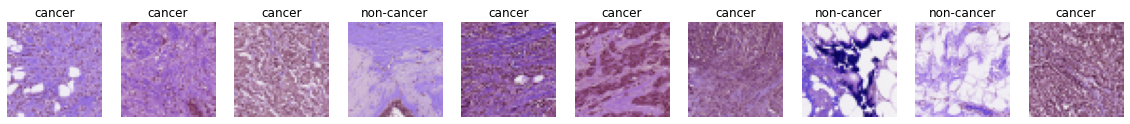

In [54]:
image_count = 10

_, axs = plt.subplots(1, image_count, figsize=(20, 20))
for i in range(image_count):
  random_idx=random.randint(0, train_x.shape[0])
  axs[i].imshow(train_x[random_idx], cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(class_names[train_y_label[random_idx]])

In [55]:
batch_size = 250
input_shape = (50, 50, 3)

num_features = 7500#50*50*3
latent_dim = 32

In [56]:
#vae = keras.models.load_model('models/vae.h5')
#encoder = keras.models.load_model('models/encoder.h5')
#decoder = keras.models.load_model('models/decoder.h5')

In [57]:
#vae = keras.models.load_model('models/vae.h5')
vae_encoder = keras.models.load_model('models/vae_encoder.h5')
vae_decoder = keras.models.load_model('models/vae_decoder.h5')

In [58]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.beta_coefficient = beta_coefficient
    
    def call(self, inputs):
        x = self.encoder(inputs)[2]
        return self.decoder(x)
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(
                    keras.losses.MSE(data, reconstruction), axis=(1, 2) # mod
                )
           # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [59]:
vae = VAE(encoder=vae_encoder, decoder=vae_decoder)
vae.compile(optimizer='adam')

In [39]:
model = vae
#model.compile( optimizer='adam')
tf.config.run_functions_eagerly(True)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
history = model.fit(train_x, epochs=20, batch_size=256, callbacks=early_stop)

Epoch 1/20


ValueError: Input 0 of layer "decoder" is incompatible with the layer: expected shape=(None, 25, 25, 3), found shape=(256, 1875)

In [20]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['kl_loss'],label='kl_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['kl_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

In [ ]:
plot_history(history)

In [ ]:
def Train_Val_Plot(loss, reconstruction_loss, kl_loss):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(loss) + 1), loss)
    ax1.set_title('History of Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(range(1, len(reconstruction_loss) + 1), reconstruction_loss)
    ax2.set_title('History of reconstruction_loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('reconstruction_loss')
    #ax1.legend(['training', 'validation'])

    #ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(kl_loss) + 1), kl_loss)

    ax3.set_title(' History of kl_loss')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('kl_loss')
    #ax3.legend(['training', 'validation'])
     

    plt.show()
    

Train_Val_Plot(history.history['loss'],
               history.history['auc'],
               history.history['precision'],
               history.history['f1_score']
               )

In [ ]:
plt.imshow(train_x[0])
plt.show()

train_x[0].shape

print(train_y[0])
print(train_y_label[0])


In [23]:
p = vae.predict(train_x[:1000])

In [ ]:
p[0].shape

In [ ]:
#vae.save_weights('weights/vae.h5')

In [21]:
vae(np.zeros((1,50,50,3)))
vae.load_weights('weights/vae.h5')

In [ ]:
plt.imshow(p[15])
plt.show()

In [ ]:
plt.imshow(train_x[15])
plt.show()


In [22]:
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        ax[0][i].imshow(np.reshape(y_true[i], (50, 50, 3)), aspect='auto')
        ax[1][i].imshow(np.reshape(y_pred[i], (50, 50, 3)), aspect='auto')
    plt.tight_layout()

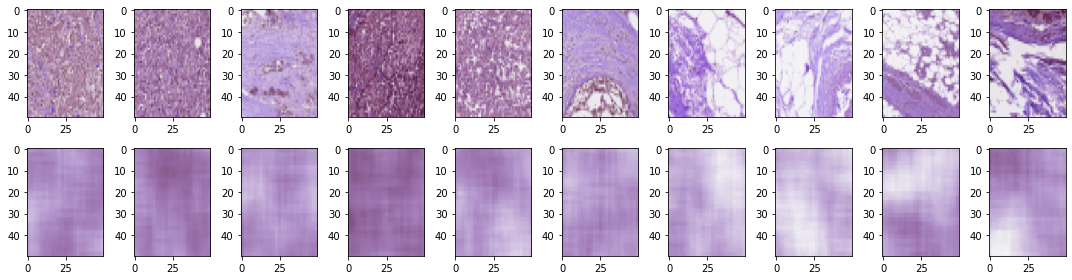

In [24]:
plot_predictions(train_x, p)

In [25]:
# Scatter with images instead of points
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
img_size = 50
def imscatter(x, y, ax, imageData, zoom):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = imageData[i]*255.
        img = img.astype(np.uint8).reshape([img_size,img_size,3])
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [26]:
#https://github.com/despoisj/LatentSpaceVisualization/blob/master/visuals.py
from sklearn import manifold

def computeTSNEProjectionOfLatentSpace(X, X_encoded, display=True, save=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    #X_encoded = encoder.predict(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = fig.add_subplot(111, facecolor='black')
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.5)
        if save:
            fig.savefig('img/t-SNE-embedding_vae.png')
        plt.show()
    else:
        return X_tsne

In [27]:
X_encoded = vae_encoder.predict(train_x[:1000])[2]
#X_encoded.shape
#need to reshape for TSNE


Computing latent space projection...
Computing t-SNE embedding...


/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/PERSONALE/nicolas.derus2/miniconda3/envs/dis_vae/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Plotting t-SNE visualization...


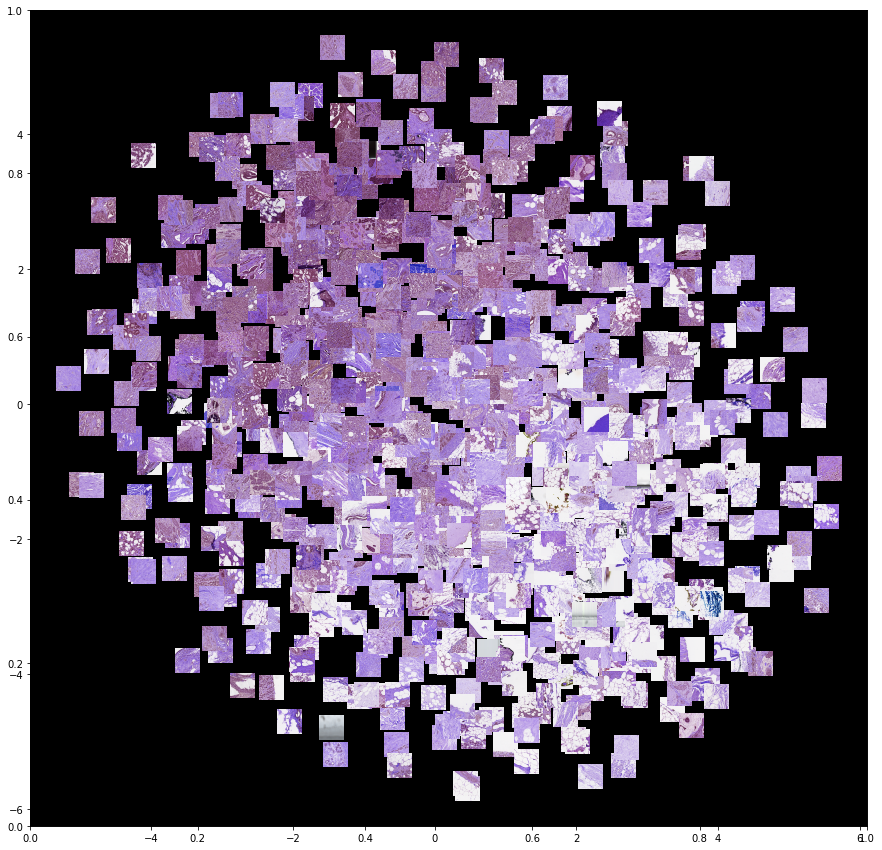

In [29]:
computeTSNEProjectionOfLatentSpace(train_x[:1000,], X_encoded[:1000,], display=True, save=True)

In [ ]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_encoded[:1000,])


In [ ]:
import pandas as pd
df = pd.DataFrame()
df['y'] = train_y_label[:1000]
df['comp-1'] = X_tsne[:,0]
df['comp-2'] = X_tsne[:,1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
colors = {0:'blue', 1:'red'}

ax.scatter(df["comp-1"], df["comp-2"], c=df['y'].map(colors), label=colors) 
ax.legend()
plt.show()

In [30]:
def computeTSNEProjectionOfPixelSpace(X, display=True):
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1, 50* 50* 3]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = fig.add_subplot(111, facecolor='black')
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.5)
        fig.savefig('img/t-SNE_original_space.png')
        plt.show()
    else:
        return X_tsne

In [ ]:
computeTSNEProjectionOfPixelSpace(train_x[:1000], display=True)

In [31]:
def getReconstructedImages(X, encoder, decoder):
    nbSamples = X.shape[0]
    nbSquares = int(math.sqrt(nbSamples))
    nbSquaresHeight = 2*nbSquares
    nbSquaresWidth = nbSquaresHeight
    resultImage = np.zeros((nbSquaresHeight*img_size,int(nbSquaresWidth*img_size/2),X.shape[-1]))

    reconstructedX = decoder.predict(encoder.predict(X)[2])

    for i in range(nbSamples) :     # 
        original = X[i]
        reconstruction = reconstructedX[i]
        rowIndex = i%nbSquaresWidth
        columnIndex = int((i-rowIndex)/nbSquaresHeight)
        resultImage[rowIndex*img_size:(rowIndex+1)*img_size,columnIndex*2*img_size:(columnIndex+1)*2*img_size,:] = np.hstack([original,reconstruction])

    return resultImage



In [32]:
# Reconstructions for samples in dataset
def visualizeReconstructedImages(X_train, X_test, encoder, decoder, save=False):
    trainReconstruction = getReconstructedImages(X_train,encoder, decoder)
    testReconstruction = getReconstructedImages(X_test,encoder, decoder)

    if not save:
        print("Generating 10 image reconstructions...")

    result = np.hstack([trainReconstruction,np.zeros([trainReconstruction.shape[0],5,trainReconstruction.shape[-1]]),testReconstruction])
    result = (result*255.).astype(np.uint8)

    if save:
        fig, ax = plt.subplots(figsize=(15, 15))
        plt.imshow(result)
        fig.savefig('img/vae_reconstructions.png')
    else:
        plt.show()


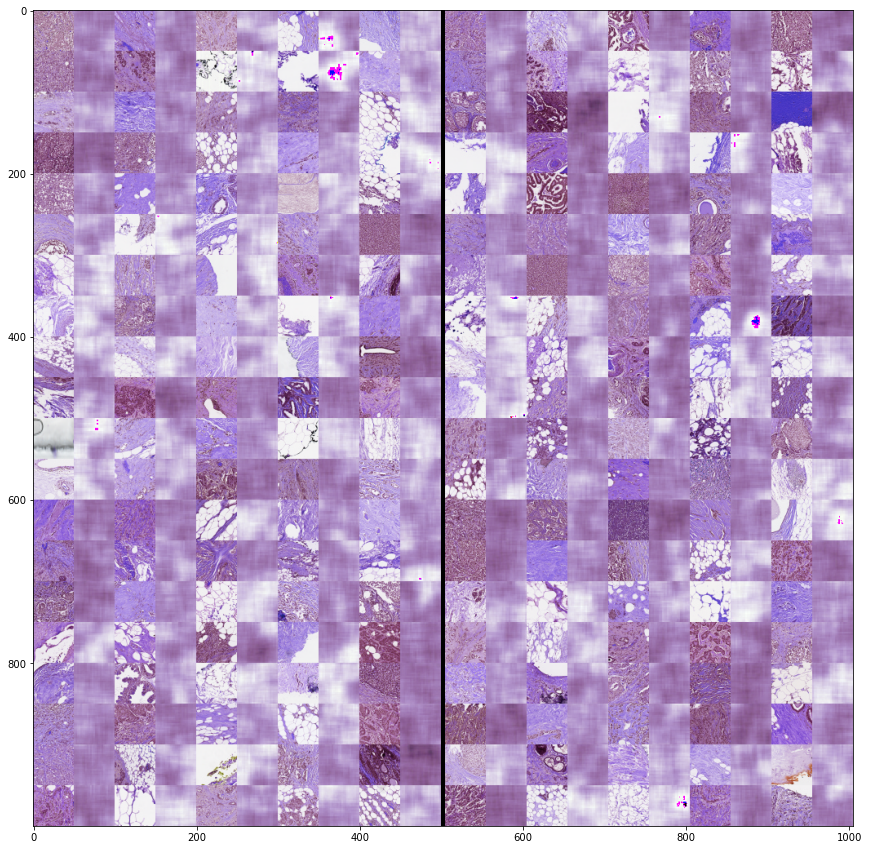

In [34]:
visualizeReconstructedImages(train_x[:100], test_x[:100],vae_encoder, vae_decoder, save =True)

In [ ]:
# Shows linear inteprolation in image space vs latent space
def visualizeInterpolation(start, end, encoder, decoder, save=False, nbSteps=5):
    print("Generating interpolations...")

    # Create micro batch
    X = np.array([start, end])

    # Compute latent space projection
    latentX = encoder.predict(X)
    latentStart, latentEnd = latentX

    # Get original image for comparison
    startImage, endImage = X

    vectors = []
    normalImages = []
    #Linear interpolation
    alphaValues = np.linspace(0, 1, nbSteps)
    for alpha in alphaValues:
        # Latent space interpolation
        vector = latentStart*(1-alpha) + latentEnd*alpha
        vectors.append(vector)
        # Image space interpolation
        blendImage = cv2.addWeighted(startImage,1-alpha,endImage,alpha,0)
        normalImages.append(blendImage)

    # Decode latent space vectors
    vectors = np.array(vectors)
    reconstructions = decoder.predict(vectors)

    # Put final image together
    resultLatent = None
    resultImage = None

    for i in range(len(reconstructions)):
        interpolatedImage = normalImages[i]*255
        interpolatedImage = cv2.resize(interpolatedImage,(50,50))
        interpolatedImage = interpolatedImage.astype(np.uint8)
        resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])

        reconstructedImage = reconstructions[i]*255.
        #reconstructedImage = reconstructedImage.reshape([28,28])
        #reconstructedImage = cv2.resize(reconstructedImage,(50,50))
        reconstructedImage = reconstructedImage.astype(np.uint8)
        resultLatent = reconstructedImage if resultLatent is None else np.hstack([resultLatent,reconstructedImage])
    
        result = np.vstack([resultImage,resultLatent])



In [ ]:
# Create micro batch
#X = np.array([start, end])
X = np.array(train_x[0:100])
# Compute latent space projection
latentX = vae_encoder.predict(X)[2]
latentX.shape

In [ ]:

latentStart = latentX[0]
latentEnd = latentX[1]
# Get original image for comparison
startImage, endImage = X

vectors = []
normalImages = []
#Linear interpolation
alphaValues = np.linspace(0, 1, 5)
for alpha in alphaValues:
    # Latent space interpolation
    vector = latentStart*(1-alpha) + latentEnd*alpha
    vectors.append(vector)
    # Image space interpolation
    blendImage = cv2.addWeighted(startImage,1-alpha,endImage,alpha,0)
    normalImages.append(blendImage)

# Decode latent space vectors
vectors = np.array(vectors)
reconstructions = vae_decoder.predict(vectors)

# Put final image together
resultLatent = None
resultImage = None

for i in range(len(reconstructions)):
    interpolatedImage = normalImages[i]*255
    interpolatedImage = cv2.resize(interpolatedImage,(50,50))
    interpolatedImage = interpolatedImage.astype(np.uint8)
    resultImage = interpolatedImage if resultImage is None else np.hstack([resultImage,interpolatedImage])

    reconstructedImage = reconstructions[i]*255.
    #reconstructedImage = reconstructedImage.reshape([28,28])
    #reconstructedImage = cv2.resize(reconstructedImage,(50,50))
    reconstructedImage = reconstructedImage.astype(np.uint8)
    resultLatent = reconstructedImage if resultLatent is None else np.hstack([resultLatent,reconstructedImage])

    result = np.vstack([resultImage,resultLatent])

In [ ]:
# Computes A, B, C, A+B, A+B-C in latent space
def visualizeArithmetics(a, b, c, encoder, decoder):
    print("Computing arithmetics...")
    # Create micro batch
    X = np.array([a,b,c])

    # Compute latent space projection
    latentA, latentB, latentC = encoder.predict(X)

    add = latentA+latentB
    addSub = latentA+latentB-latentC

    # Create micro batch
    X = np.array([latentA,latentB,latentC,add,addSub])

    # Compute reconstruction
    reconstructedA, reconstructedB, reconstructedC, reconstructedAdd, reconstructedAddSub = decoder.predict(X)

    cv2.imshow("Arithmetics in latent space",np.hstack([reconstructedA, reconstructedB, reconstructedC, reconstructedAdd, reconstructedAddSub]))
    cv2.waitKey()
